In [22]:
from sklearn.manifold import SpectralEmbedding
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from scipy import stats
from sklearn.feature_selection import SelectKBest, f_regression, chi2
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.feature_selection import mutual_info_classif


In [3]:
def split_labels(df, cols):
    '''split the dataframe into predicting table and labels
       df: given dataset
       cols: list of labels
    '''
    return df[[i for i in df if i not in cols]], df[cols]

def kNN(X_train,y_train, X_test):
#     print('implementing kNN...')
    from sklearn.neighbors import KNeighborsClassifier

    # assuming X is your data and k is the number of clusters
    clf = KNeighborsClassifier(n_neighbors=10)
    clf.fit(X_train, y_train)
    return clf.predict(X_test)

def Logistic(X_train,y_train, X_test):
    clf = LogisticRegression(max_iter=10000, penalty='l1', C=1.6, solver= 'liblinear')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)    
    X_train,y_train, X_test = None, None, None
    return y_pred

   
def CART(X_train,y_train, X_test):
    clf = DecisionTreeClassifier(max_depth=5)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    X_train,y_train, X_test = None, None, None
    return y_pred

def one_split(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
    return X_train, X_test, y_train, y_test 

def get_classification_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]
    sensitivity = []
    specificity = []
    for i in range(num_classes):
        tp = cm[i,i]
        fn = np.sum(cm[i,:]) - tp
        fp = np.sum(cm[:,i]) - tp
        tn = np.sum(cm) - tp - fp - fn
        
        sensitivity_i = tp / (tp + fn)
        specificity_i = tn / (tn + fp)
        sensitivity.append(sensitivity_i)
        specificity.append(specificity_i)
    
    macro_sensitivity = np.mean(sensitivity)
    macro_specificity = np.mean(specificity)
#     print(accuracy, macro_sensitivity, macro_specificity)
    return accuracy, macro_sensitivity, macro_specificity

def predict(X,Y, predictors):
    X_train, X_test, y_train, y_test = one_split(X, Y)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    pred_Y = [pred(X_train, np.ravel(y_train), X_test) for pred in predictors]
    return [get_classification_metrics(y_test, p) for p in pred_Y]

def PCA_model(X, n = 2):
    pca = PCA(n_components=n)
    pca.fit(X)
    X_pca = pca.transform(X)
    return X_pca

def SE_rbf(X, n=2):
    sigma = 0.1
    se = SpectralEmbedding(n_components=n, affinity='rbf', n_neighbors=30, gamma=1 / (2 * sigma ** 2))
    X_CE = se.fit_transform(X)
    return X_CE

def SE_nn(X, n=2):
    se = SpectralEmbedding(n_components=n, affinity='nearest_neighbors', n_neighbors=50, eigen_solver='arpack')
    X_CE = se.fit_transform(X)
    return X_CE

# -------------------------------------------------------------------


# Dataset1

In [3]:
df1 = pd.read_csv('heart.csv')

# Preprocessing
dataset = df1
from pandas import get_dummies
a = pd.get_dummies(dataset['sex'], prefix = "sex")
b = pd.get_dummies(dataset['cp'], prefix = "cp")
c = pd.get_dummies(dataset['fbs'], prefix = "fbs")
d = pd.get_dummies(dataset['restecg'], prefix = "restecg")
e = pd.get_dummies(dataset['exang'], prefix = "exang")
f = pd.get_dummies(dataset['slope'], prefix = "slope")
g = pd.get_dummies(dataset['ca'], prefix = "ca")
h = pd.get_dummies(dataset['thal'], prefix = "thal")

frames = [dataset, a, b, c, d, e, f, g, h]
dataset2 = pd.concat(frames, axis = 1)
dataset2 = dataset2.drop(columns = ['sex','cp', 'fbs', 'restecg','exang','slope','ca','thal'])

df1 = dataset2
X1, Y1 = split_labels(df1, ['target'])

## Dataset1 - PCA 

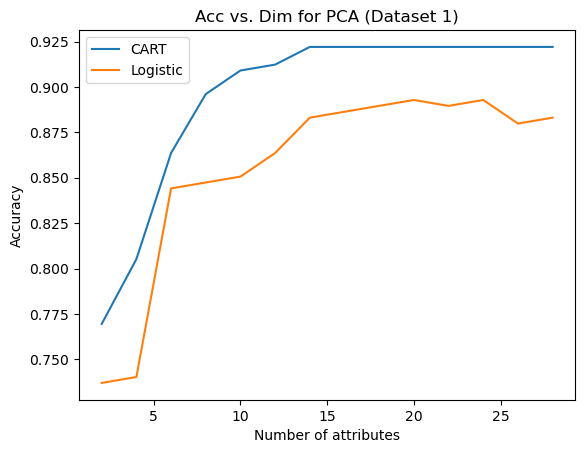

In [4]:
# Doing PCA...
All = {}
for NoF in range (2, X1.shape[1], 2): # Number of features
    X1s = PCA_model(X1, NoF) # dimension reduction
    results1 = predict(X1s, np.ravel(Y1), [CART, Logistic]) # Machine learning models
    
    All[NoF] = [results1[0][0], results1[1][0]]

num = [f for f in All]
cart = [All[f][0] for f in All]
logistic = [All[f][1] for f in All]
fdf = pd.DataFrame({'Number of attributes': num, 
                    'CART': cart,
                    'Logistic': logistic})
# -------------------------------------------------------------------
import matplotlib.pyplot as plt
fdf.plot(x='Number of attributes', y=['CART', 'Logistic'])
plt.legend()
plt.ylabel('Accuracy')
plt.title("Acc vs. Dim for PCA (Dataset 1)")
plt.show()

## Dataset1 - Spectral embedding

In [11]:
X1, Y1 = split_labels(df1, ['target'])
All_nn = {}
print(X1.shape[1])
X_train, X_test, y_train, y_test = one_split(X1, Y1)
SE = SE_nn

scaler = StandardScaler()
X_train1 = scaler.fit_transform(X_train)
for NoF in range (2, X1.shape[1], 2): # Number of features
    # calculate the embedding representation of the train dataset

    X_train_SE = SE(X_train1, NoF)   
    X_test_SE = pd.DataFrame(columns=[i for i in range(NoF)])    
    
    # take one datapoint and find its embedding and adding it to new embedded test set
    for _, row in X_test.iterrows():
        X_tr = X_train.copy()
        X_tr.loc[len(X_tr)] = row
        
        X_train2 = scaler.transform(X_tr)
        X_tr_SE = SE(X_train2, NoF)
        
        nn = X_tr_SE[-1]
        X_test_SE.loc[len(X_test_SE)] = nn
    
    pred_Y  = [f(X_train_SE, np.ravel(y_train), X_test_SE) for f in [CART, Logistic] ]
    results = [get_classification_metrics(y_test, p) for p in pred_Y]

    All[NoF] = [results[0][0], results[1][0]]
    print(NoF, results[0][0], results[1][0])   

print('Spectral embedding nn')



30


KeyboardInterrupt: 

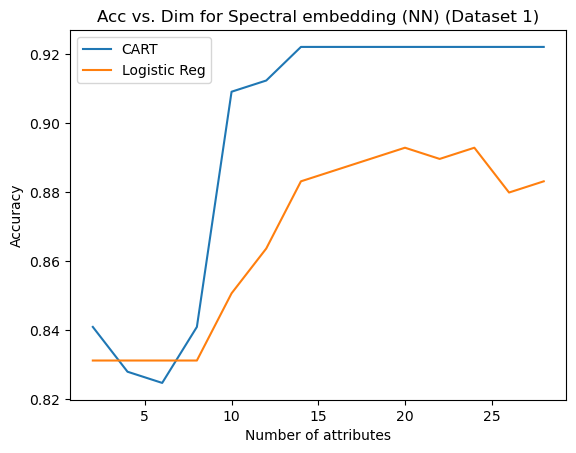

In [6]:
num = [f for f in All]
cart = [All[f][0] for f in All]
logistic = [All[f][1] for f in All]
fdf = pd.DataFrame({'Number of attributes': num, 
                    'CART': cart,
                    'Logistic Reg': logistic})
# -------------------------------------------------------------------
import matplotlib.pyplot as plt
fdf.plot(x='Number of attributes', y=['CART', 'Logistic Reg'])
plt.legend()
plt.ylabel('Accuracy')
plt.title("Acc vs. Dim for Spectral embedding (NN) (Dataset 1)")
plt.show()

In [4]:
df1 = pd.read_csv('heart.csv')

# Preprocessing
dataset = df1
from pandas import get_dummies
a = pd.get_dummies(dataset['sex'], prefix = "sex")
b = pd.get_dummies(dataset['cp'], prefix = "cp")
c = pd.get_dummies(dataset['fbs'], prefix = "fbs")
d = pd.get_dummies(dataset['restecg'], prefix = "restecg")
e = pd.get_dummies(dataset['exang'], prefix = "exang")
f = pd.get_dummies(dataset['slope'], prefix = "slope")
g = pd.get_dummies(dataset['ca'], prefix = "ca")
h = pd.get_dummies(dataset['thal'], prefix = "thal")

frames = [dataset, a, b, c, d, e, f, g, h]
dataset2 = pd.concat(frames, axis = 1)
dataset2 = dataset2.drop(columns = ['sex','cp', 'fbs', 'restecg','exang','slope','ca','thal'])

df1 = dataset2


In [21]:
X1, Y1 = split_labels(df1, ['target'])
All_nn = {}
print('Working...')
X_train, X_test, y_train, y_test = one_split(X1, Y1)
SE = SE_nn

scaler = StandardScaler()
X_train1 = scaler.fit_transform(X_train)
NoF = 14
X_train_SE = SE(X_train1, NoF)   
X_test_SE = pd.DataFrame(columns=[i for i in range(NoF)])    

# take one datapoint and find its embedding and adding it to new embedded test set
for _, row in X_test.iterrows():
    X_tr = X_train.copy()
    X_tr.loc[len(X_tr)] = row

    X_train2 = scaler.transform(X_tr)
    X_tr_SE = SE(X_train2, NoF)

    nn = X_tr_SE[-1]
    X_test_SE.loc[len(X_test_SE)] = nn

pred_Y  = CART(X_train_SE, np.ravel(y_train), X_test_SE)
results = get_classification_metrics(y_test, pred_Y)

print(f'CART , NoF = {NoF} = {results}')   
print("Accuracy of CART:",accuracy_score(y_test, pred_Y)*100,'\n')
print(classification_report(y_test, pred_Y))



Working...
CART , NoF = 14 = (0.8701298701298701, 0.8689232071081023, 0.8689232071081023)
Accuracy of CART: 87.01298701298701 

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       145
           1       0.87      0.89      0.88       163

    accuracy                           0.87       308
   macro avg       0.87      0.87      0.87       308
weighted avg       0.87      0.87      0.87       308



NameError: name 'precision_recall_fscore_support' is not defined

In [23]:
res = []
for l in [0,1]:
    prec,recall,_,_ = precision_recall_fscore_support(np.array(y_test)==l,
                                                      np.array(pred_Y)==l,
                                                      pos_label=True,average=None)
    res.append([l,recall[0],recall[1]])
    

pd.DataFrame(res,columns = ['class','sensitivity','specificity'])

,class,sensitivity,specificity
0,0,0.889571,0.848276
1,1,0.848276,0.889571


In [24]:
X1, Y1 = split_labels(df1, ['target'])
All_nn = {}
print('working....')
X_train, X_test, y_train, y_test = one_split(X1, Y1)
SE = SE_nn

scaler = StandardScaler()
X_train1 = scaler.fit_transform(X_train)
NoF = 20
X_train_SE = SE(X_train1, NoF)   
X_test_SE = pd.DataFrame(columns=[i for i in range(NoF)])    

# take one datapoint and find its embedding and adding it to new embedded test set
for _, row in X_test.iterrows():
    X_tr = X_train.copy()
    X_tr.loc[len(X_tr)] = row

    X_train2 = scaler.transform(X_tr)
    X_tr_SE = SE(X_train2, NoF)

    nn = X_tr_SE[-1]
    X_test_SE.loc[len(X_test_SE)] = nn

pred_Y  = Logistic(X_train_SE, np.ravel(y_train), X_test_SE)
results = get_classification_metrics(y_test, pred_Y)

print(f'Logistic Regression , NoF = {NoF} = {results}')  
print("Accuracy of Logistic Regression:",accuracy_score(y_test, pred_Y)*100,'\n')
print(classification_report(y_test, pred_Y))

res = []
for l in [0,1]:
    prec,recall,_,_ = precision_recall_fscore_support(np.array(y_test)==l,
                                                      np.array(pred_Y)==l,
                                                      pos_label=True,average=None)
    res.append([l,recall[0],recall[1]])
    

pd.DataFrame(res,columns = ['class','sensitivity','specificity'])

working....
Logistic Regression , NoF = 20 = (0.8311688311688312, 0.8313518087581976, 0.8313518087581976)
Accuracy of Logistic Regression: 83.11688311688312 

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       145
           1       0.85      0.83      0.84       163

    accuracy                           0.83       308
   macro avg       0.83      0.83      0.83       308
weighted avg       0.83      0.83      0.83       308



,class,sensitivity,specificity
0,0,0.828221,0.834483
1,1,0.834483,0.828221
